In [4]:
import os
os.chdir('..')
!source r2r/bin/activate r2r

zsh:source:1: no such file or directory: r2r/bin/activate


In [3]:
import json
import sys
sys.path.append('build')
import MatterSim
import time
import numpy as np
import skimage.transform
import networkx as nx

import matplotlib.pyplot as plt
%matplotlib inline

ModuleNotFoundError: No module named 'MatterSim'

In [3]:
# panorama trajectories available in
# http://gpu.ronghanghu.com/misc/text_navi/eval_outputs/selfplay_glove_sample_pragmatics_40_state_factored/
trajectory_path = '/home/ronghang/public_html/misc/text_navi/eval_outputs/selfplay_glove_sample_pragmatics_40_state_factored/eval_v2_val_unseen_sw_0.95.json'

instruction_path = '/data/ronghang/DATASETS/Matterport3DSimulator/tasks/R2R/data/R2R_val_unseen.json'

graph_path = '/data/ronghang/DATASETS/Matterport3DSimulator/connectivity/%s_connectivity.json'

In [4]:
idx = 100  # the trajectory index to visualize

In [6]:
# load navigation graph to calculate the relative heading of the next location
def load_nav_graph(graph_path):
    with open(graph_path) as f:
        G = nx.Graph()
        positions = {}
        data = json.load(f)
        for i,item in enumerate(data):
            if item['included']:
                for j,conn in enumerate(item['unobstructed']):
                    if conn and data[j]['included']:
                        positions[item['image_id']] = np.array([item['pose'][3], 
                                item['pose'][7], item['pose'][11]]);
                        assert data[j]['unobstructed'][i], 'Graph should be undirected'
                        G.add_edge(item['image_id'],data[j]['image_id'])
        nx.set_node_attributes(G, values=positions, name='position')
    return G

def compute_rel_heading(graph, current_viewpoint, current_heading, next_viewpoint):
    if current_viewpoint == next_viewpoint:
        return 0.
    target_rel = graph.node[next_viewpoint]['position'] - graph.node[current_viewpoint]['position']
    target_heading = np.pi/2.0 - np.arctan2(target_rel[1], target_rel[0]) # convert to rel to y axis
    
    rel_heading = target_heading - current_heading
    # normalize angle into turn into [-pi, pi]
    rel_heading = rel_heading - (2*np.pi) * np.floor((rel_heading + np.pi) / (2*np.pi))
    return rel_heading

In [11]:
with open(trajectory_path) as f:
    trajectory_data = json.load(f)
with open(instruction_path) as f:
    instruction_data = json.load(f)
    
instr_id2txt = {
    ('%s_%d' % (d['path_id'], n)): txt for d in instruction_data for n, txt in enumerate(d['instructions'])}
instr_id2scan = {
    ('%s_%d' % (d['path_id'], n)): d['scan'] for d in instruction_data for n, txt in enumerate(d['instructions'])}

graphs = {scan: load_nav_graph(graph_path % scan) for scan in instr_id2scan.values()}

In [7]:
def visualize_panorama_img(scan, viewpoint, heading, elevation):
    WIDTH = 80
    HEIGHT = 480
    pano_img = np.zeros((HEIGHT, WIDTH*36, 3), np.uint8)
    VFOV = np.radians(55)
    sim = MatterSim.Simulator()
    sim.setCameraResolution(WIDTH, HEIGHT)
    sim.setCameraVFOV(VFOV)
    sim.init()
    for n_angle, angle in enumerate(range(-175, 180, 10)):
        sim.newEpisode(scan, viewpoint, heading + np.radians(angle), elevation)
        state = sim.getState()
        im = state.rgb
        pano_img[:, WIDTH*n_angle:WIDTH*(n_angle+1), :] = im[..., ::-1]
    return pano_img

def visualize_tunnel_img(scan, viewpoint, heading, elevation):
    WIDTH = 640
    HEIGHT = 480
    VFOV = np.radians(60)
    sim = MatterSim.Simulator()
    sim.setCameraResolution(WIDTH, HEIGHT)
    sim.setCameraVFOV(VFOV)
    sim.init()
    sim.newEpisode(scan, viewpoint, heading, elevation)
    state = sim.getState()
    im = state.rgb
    return im[..., ::-1].copy()

In [12]:
trajectory = trajectory_data[idx]
instr_id = trajectory['instr_id']
scan = instr_id2scan[instr_id]
txt = instr_id2txt[instr_id]

graph = graphs[scan]

Turn left and exit the room. Keep walking along the hall past the kitchen area. Wait by the doorway to the dining table area. 


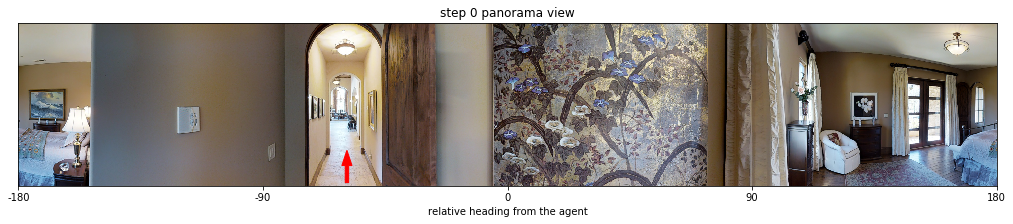

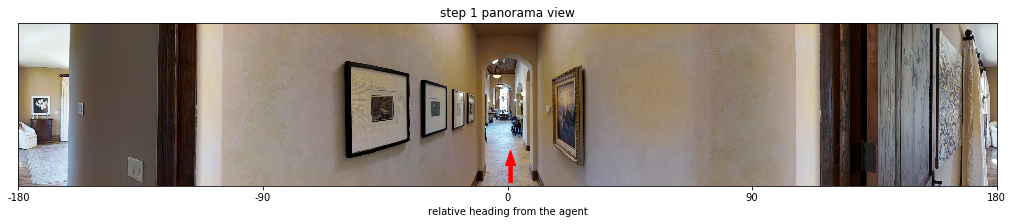

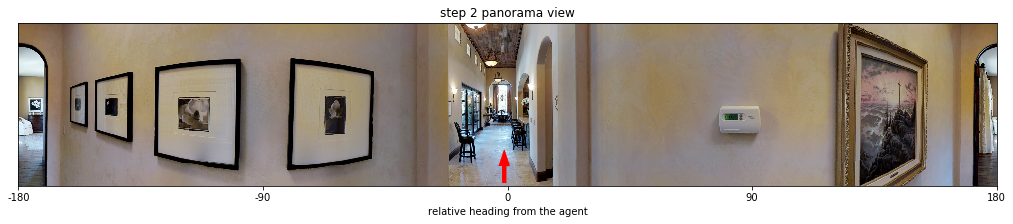

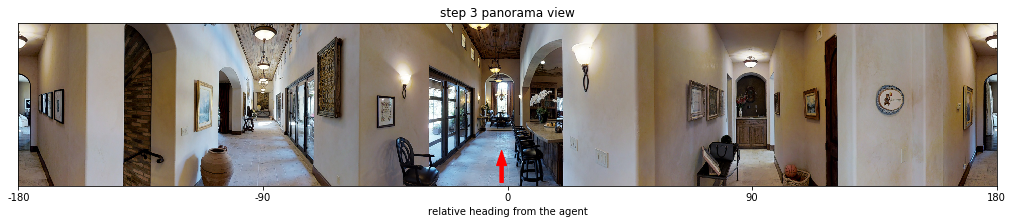

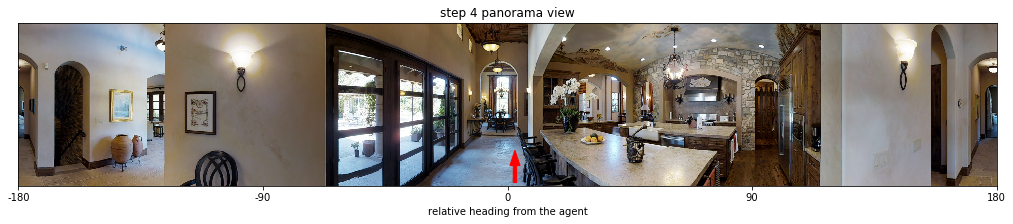

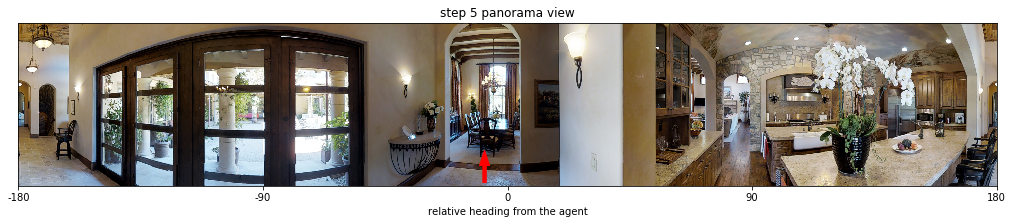

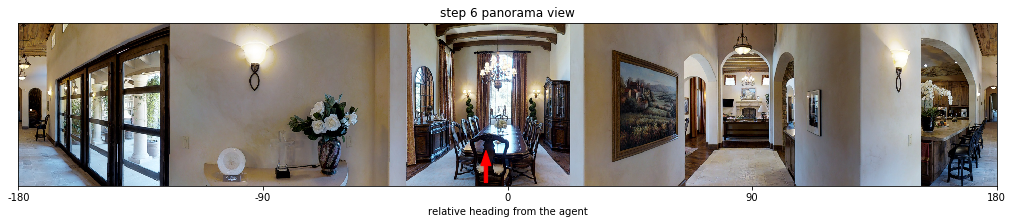

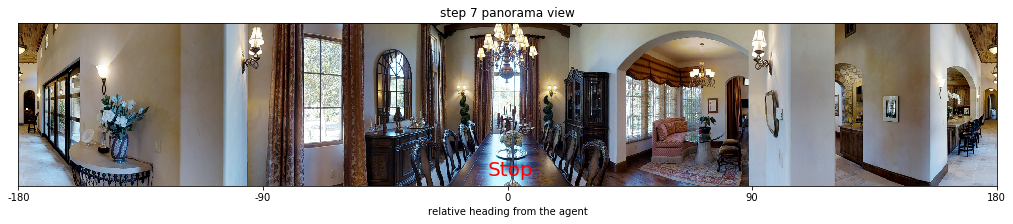

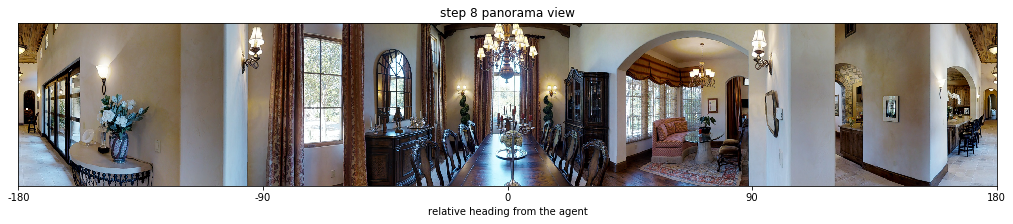

In [9]:
plt.close('all')
print(txt)
for n, (viewpoint, heading, elevation) in enumerate(trajectory['trajectory']):
    plt.figure(figsize=(18, 3))
    im = visualize_panorama_img(scan, viewpoint, heading, 0)    
    plt.imshow(im)
    plt.xticks(np.linspace(0, im.shape[1] - 1, 5), [-180, -90, 0, 90, 180])
    plt.xlabel('relative heading from the agent')
    plt.yticks([], [])
    plt.title('step %d panorama view' % n)
    if n + 1 < len(trajectory['trajectory']):
        next_viewpoint, _, _ = trajectory['trajectory'][n+1]
        if next_viewpoint != viewpoint:
            rel_heading = compute_rel_heading(graph, viewpoint, heading, next_viewpoint)
            next_im_x = (rel_heading / (2*np.pi) + 0.5) * im.shape[1]
            plt.arrow(next_im_x, im.shape[0] - 10, 0, -50, width=10, color='r')
        else:
            plt.text(im.shape[1] // 2 - 60, im.shape[0] - 30, 'Stop', fontsize=20, color='r')